# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "4")  # кол-во  executor'ов
conf.set("spark.executor.cores", "4")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2021-02-16 15:25 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-16 15:25 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-16 15:25 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-16 15:25 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-16 15:25 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2021-02-16 19:01 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2021-02-16 15:25 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-16 15:25 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-16 15:25 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-16 15:25 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
%%time
ratings.take(5)

CPU times: user 10 ms, sys: 1.96 ms, total: 12 ms
Wall time: 1.84 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 11 ms, sys: 8.98 ms, total: 20 ms
Wall time: 52.9 s


162541

Сохраним датасет в память

In [12]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 19.6 ms, sys: 5.09 ms, total: 24.7 ms
Wall time: 1min 25s


162541

Количество фильмов

In [14]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 14.3 ms, sys: 3.83 ms, total: 18.2 ms
Wall time: 25 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [15]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [16]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating = movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)

movie_avg_rating.take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [17]:
!hdfs dfs -rm -R data/ml-25m/movie_avg_rating

Deleted data/ml-25m/movie_avg_rating


In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
!hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-16 19:19 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup     351301 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     370920 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     409146 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     398803 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     355862 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     413358 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     307217 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     305264 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     357361 2021-02-16 19:19 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

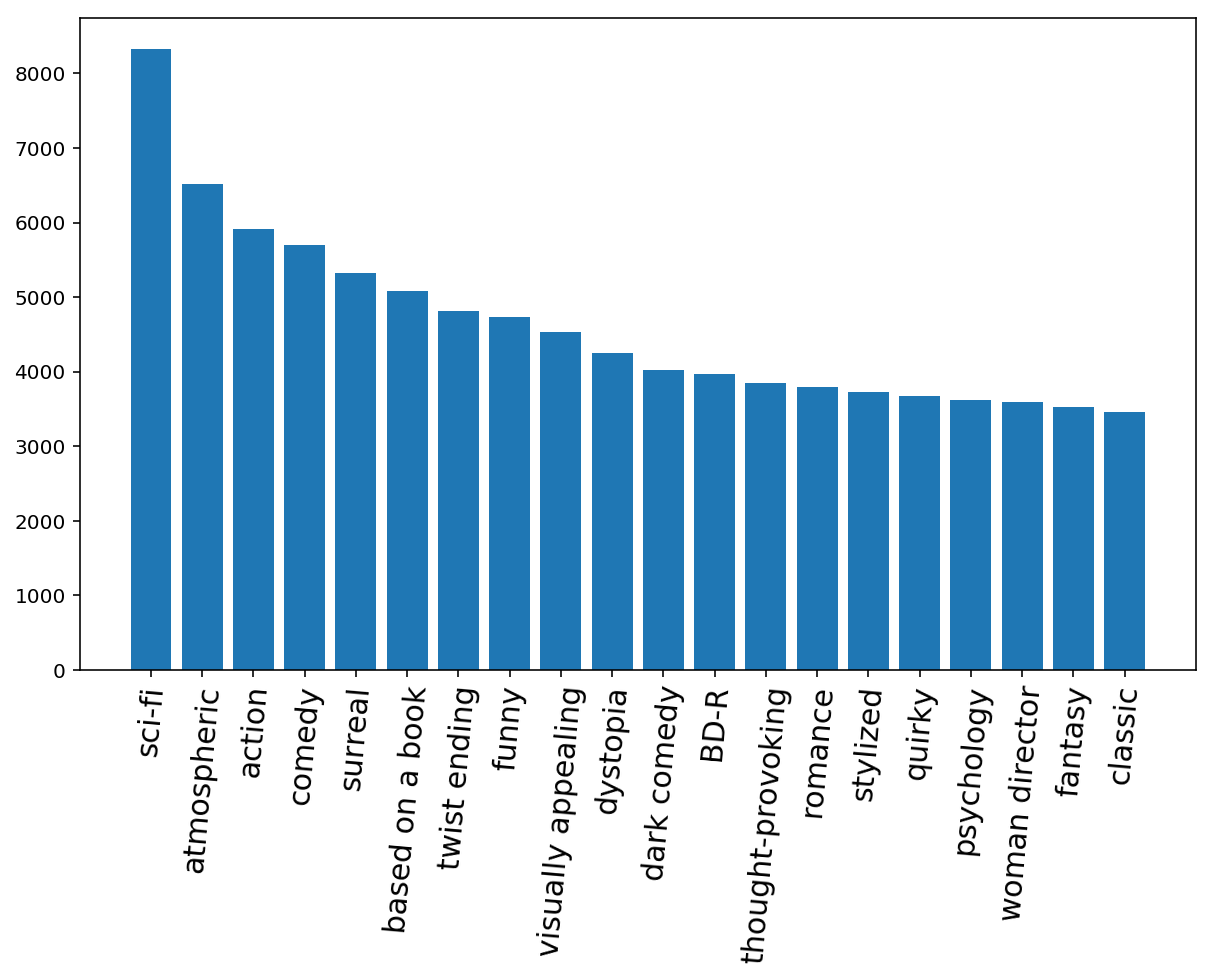

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
%%time

ratings_per_movie_count = ratings\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)

ratings_per_movie_count = ratings_per_movie_count\
    .join(movies)\
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda values: (values[1][0], values[1][1][1]))

ratings_per_movie_count.take(10)

CPU times: user 47.3 ms, sys: 13.8 ms, total: 61.1 ms
Wall time: 26.9 s


[(81491, 'Forrest Gump (1994)'),
 (81482, '"Shawshank Redemption'),
 (79672, 'Pulp Fiction (1994)'),
 (74127, '"Silence of the Lambs'),
 (72674, '"Matrix'),
 (68717, 'Star Wars: Episode IV - A New Hope (1977)'),
 (64144, 'Jurassic Park (1993)'),
 (60411, "Schindler's List (1993)"),
 (59184, 'Braveheart (1995)'),
 (58773, 'Fight Club (1999)')]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
%%time

max_rating_count = ratings\
    .filter(lambda r: r.rating == 5)\
    .map(lambda r: (r.movie_id, 1))\
    .reduceByKey(lambda a, b: a + b)

max_rating_count\
    .join(movies)\
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda values: (values[1][0], values[1][1][1]))\
    .take(10)

CPU times: user 51.5 ms, sys: 9.74 ms, total: 61.2 ms
Wall time: 23.4 s


[(39553, '"Shawshank Redemption'),
 (32169, 'Pulp Fiction (1994)'),
 (25918, 'Forrest Gump (1994)'),
 (25804, 'Star Wars: Episode IV - A New Hope (1977)'),
 (25482, '"Matrix'),
 (24853, "Schindler's List (1993)"),
 (24801, '"Silence of the Lambs'),
 (24418, '"Godfather'),
 (21585, '"Usual Suspects'),
 (21486, 'Fight Club (1999)')]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

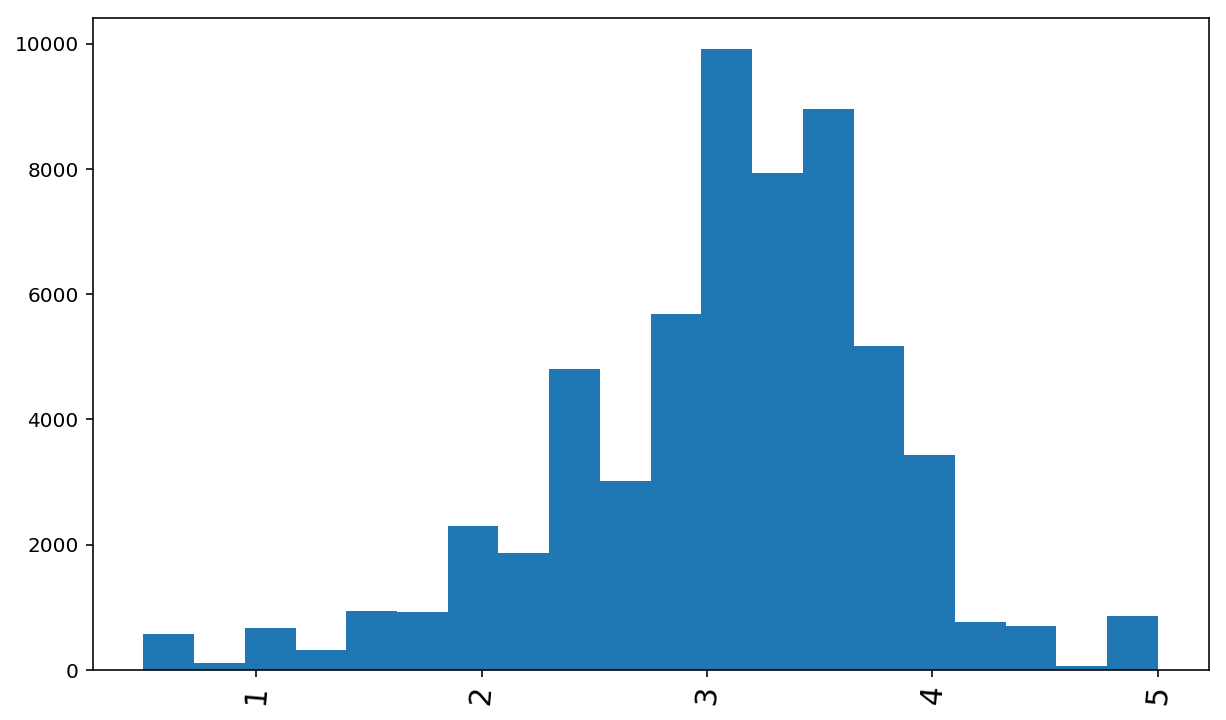

CPU times: user 526 ms, sys: 366 ms, total: 892 ms
Wall time: 560 ms


In [26]:
%%time

l_movie_avg_rating = movie_avg_rating\
    .map(lambda values: values[1][0])\
    .collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.hist(l_movie_avg_rating, bins=20)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

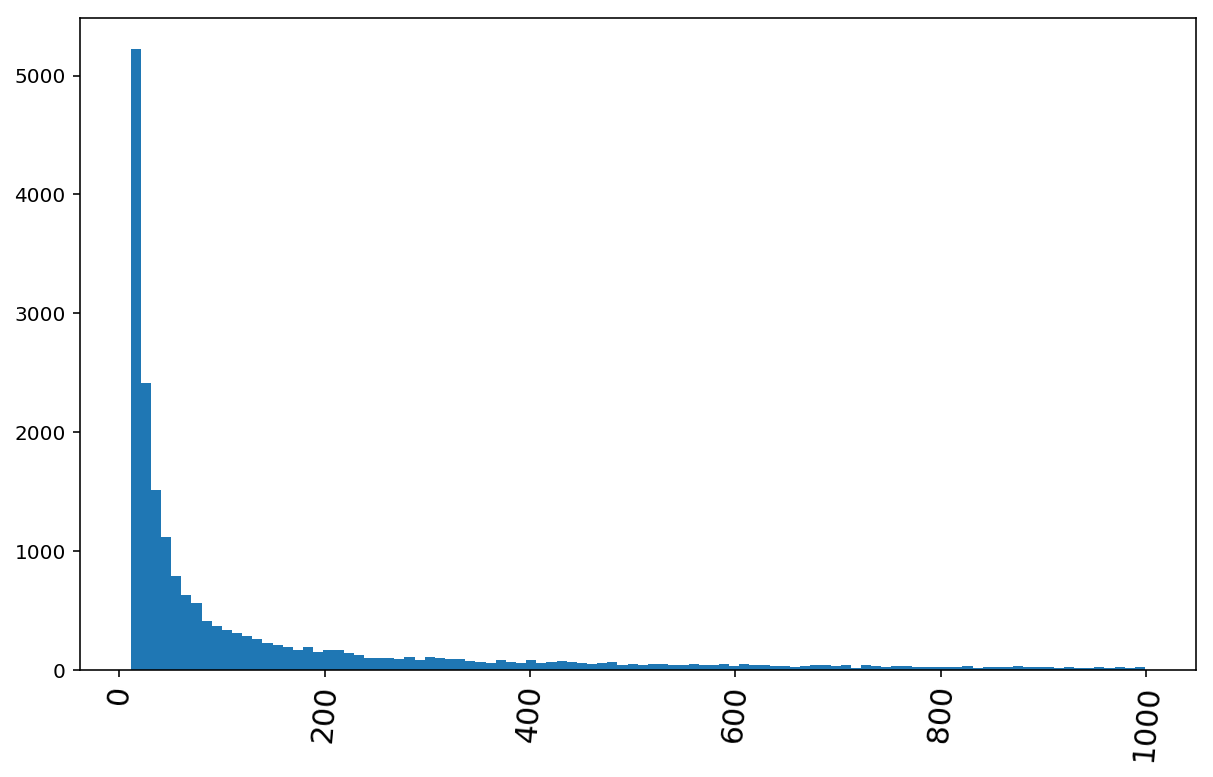

CPU times: user 733 ms, sys: 378 ms, total: 1.11 s
Wall time: 835 ms


In [27]:
%%time

# extract rating count with filtering "outliers"
l_ratings_per_movie_count = ratings_per_movie_count\
    .map(lambda values: values[0])\
    .filter(lambda counts: 10 < counts < 1000)\
    .collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.hist(l_ratings_per_movie_count, bins=100)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

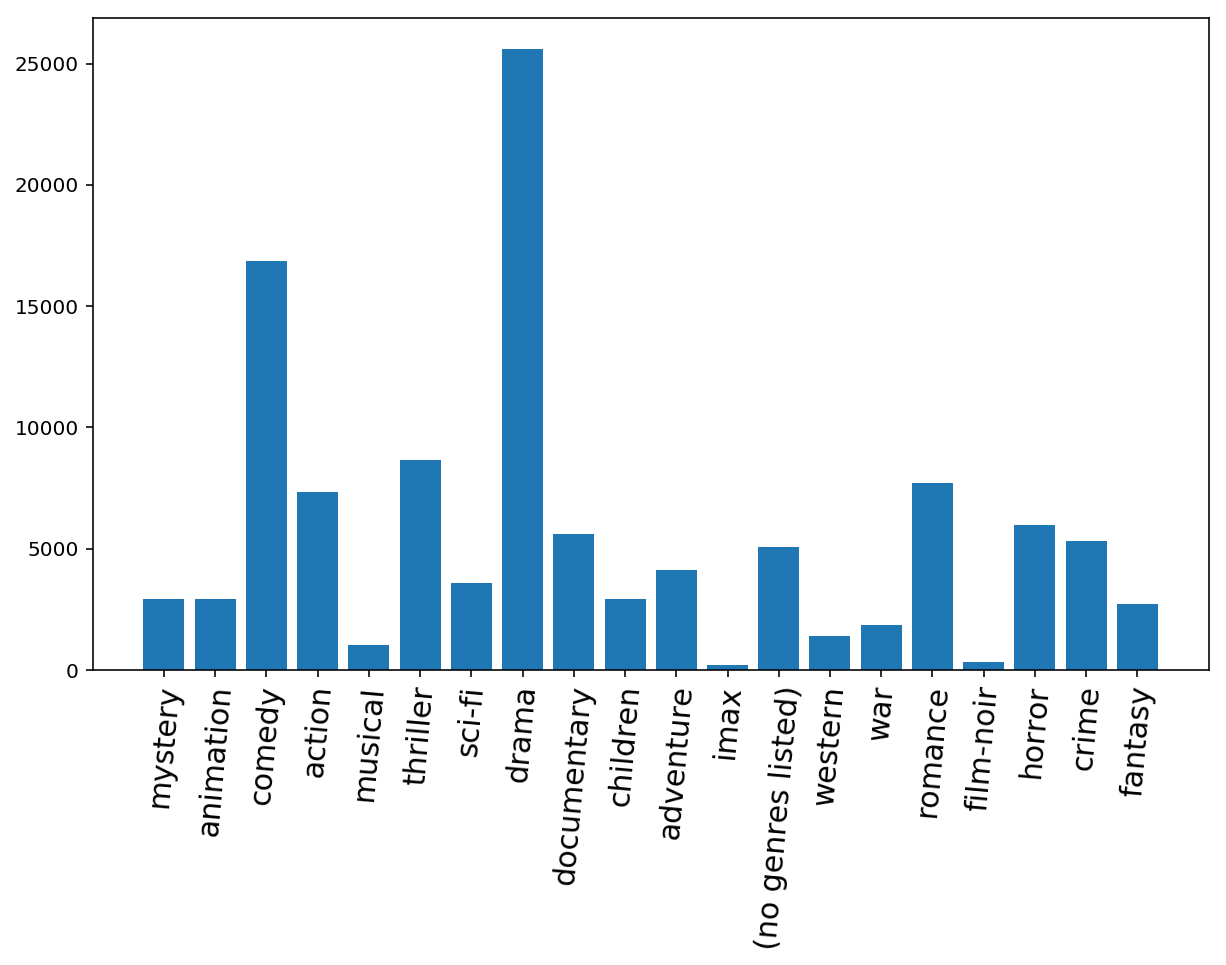

CPU times: user 624 ms, sys: 363 ms, total: 988 ms
Wall time: 865 ms


In [28]:
%%time

full_movies = sc.textFile(MOVIES_PATH)\
    .map(lambda s: s.split(','))\
    .map(lambda row: (row[0], ",".join(row[1:-1]), row[-1]))\
    .filter(lambda arr: arr[0].isdigit())

genres_count = full_movies\
    .flatMap(lambda movie: movie[2].split("|"))\
    .map(lambda genre: (genre.lower(), 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

labels, counts = zip(*genres_count)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(labels, counts)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [29]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [30]:
links = sc.textFile(LINKS_PATH).map(lambda raw: raw.split(",")).filter(lambda row: row[0].isdigit())

In [31]:
tmdb = sqlContext.read.json(TMDB_PATH).rdd.filter(lambda row: row.casts is not None)

In [32]:
tom_hanks_films = tmdb\
    .map(lambda row: (row.original_title, [cast.id for cast in row.casts.cast]))\
    .filter(lambda movie: 31 in movie[1])\
    .map(lambda movie: movie[0])\
    .collect()

print("; ".join(tom_hanks_films))

Toy Story; Apollo 13; Forrest Gump; Philadelphia; Sleepless in Seattle; The Celluloid Closet; That Thing You Do!; Saving Private Ryan; The 'Burbs; Splash; The Money Pit; Nothing in Common; You've Got Mail; Big; Return with Honor; Toy Story 2; The Bonfire of the Vanities; The Green Mile; A League of Their Own; Volunteers; Bachelor Party; Punchline; Cast Away; Turner & Hooch; He Knows You're Alone; Joe Versus the Volcano; Road to Perdition; Catch Me If You Can; Radio Flyer; Dragnet; The Ladykillers; The Terminal; The Man with One Red Shoe; The Polar Express; The Da Vinci Code; Cars; The Simpsons Movie; Charlie Wilson's War; The Great Buck Howard; Angels & Demons; Shooting War; Toy Story 3; The Pixar Story; Larry Crowne; Extremely Loud & Incredibly Close; Beyond All Boundaries; Cloud Atlas; Captain Phillips; Toy Story of Terror!; Saving Mr. Banks; Killing Lincoln; Hawaiian Vacation; Small Fry; Elvis Has Left the Building; Partysaurus Rex; Toy Story That Time Forgot; And the Oscar Goes To.

In [33]:
tmdb\
    .flatMap(lambda row: [(cast.name, 1) for cast in row.casts.cast])\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda actor: actor[1], ascending=False)\
    .take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [34]:
full_movies_with_year = full_movies\
    .keyBy(lambda row: int(row[0]))\
    .join(
        links.keyBy(lambda row: int(row[0]))
    )\
    .filter(lambda values: values[1][1][2].isdigit())\
    .map(lambda values: (int(values[1][1][2]), (values[1][0][1:])))\
    .join(
        tmdb\
            .filter(lambda row: row.release_date != '')\
            .map(lambda row: (row.id, int(row.release_date[:4])))\
            .keyBy(lambda row: int(row[0]))
    )\
    .map(lambda values: (values[1][0][0], values[1][0][1], values[1][1][1]))


full_movies_with_year.take(10)

[("Daleks' Invasion Earth: 2150 A.D. (1966)", 'Adventure|Sci-Fi', 1966),
 ('Teen Vamp (1988)', 'Comedy|Horror', 1988),
 ('Interlude In Prague (2017)', '(no genres listed)', 2017),
 ('What Will You Do When You Catch Me? (Co mi zrobisz jak mnie zlapiesz?) (1978)',
  'Comedy|Crime',
  1978),
 ('American Beauty (1999)', 'Drama|Romance', 1999),
 ('Wedding in Galilee (1988)', 'Drama|Romance', 1988),
 ('"Endless Summer, The (1966)"', 'Documentary', 1966),
 ('Walkover (1965)', '(no genres listed)', 1965),
 ('Lee Rock (1991)', 'Action|Crime|Drama', 1991),
 ('The Monkey Hustle (1976)', 'Action', 1976)]

In [35]:
genre_per_year = full_movies_with_year\
    .filter(lambda movie: movie[1] != "(no genres listed)")\
    .flatMap(lambda movie: [(genre, movie[2], 1) for genre in movie[1].split("|")])\
    .groupBy(lambda row: (row[0], row[1]))\
    .map(lambda row: (row[0][0], row[0][1], len(row[1])))

min_year = genre_per_year.map(lambda row: row[1]).min()
max_year = genre_per_year.map(lambda row: row[1]).max()
min_year, max_year

(1874, 2021)

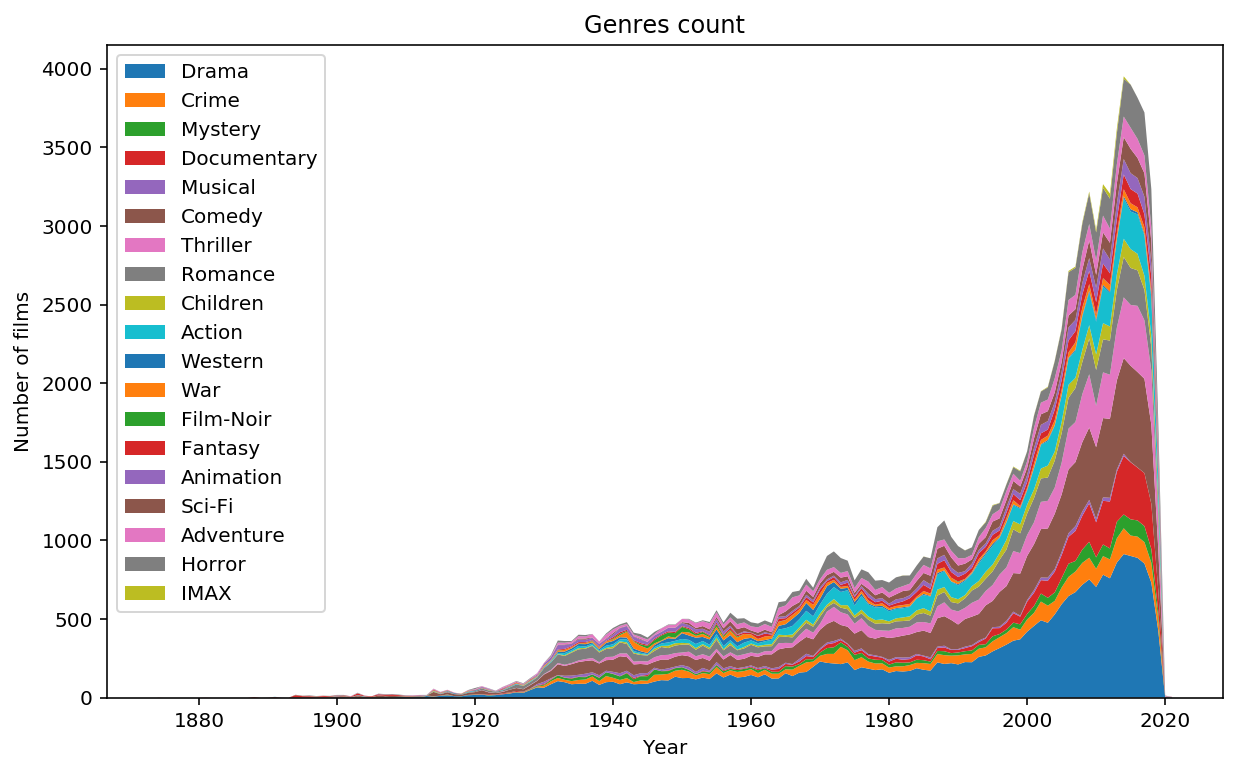

In [36]:
def convert_history_to_buckets(history):
    result = [0 for _ in range(min_year, max_year + 1)]
    for _, year, count in history:
        result[year - min_year] += count
    return result

history_count_genres = genre_per_year\
    .groupBy(lambda row: row[0])\
    .map(lambda row: (row[0], convert_history_to_buckets(row[1])))

years = range(min_year, max_year + 1)
stackplot_data = dict(history_count_genres.collect())

f, ax = plt.subplots(figsize=(10, 6))
plt.stackplot(years, stackplot_data.values(), labels=stackplot_data.keys())
ax.legend(loc='upper left')
ax.set_title('Genres count')
ax.set_xlabel('Year')
ax.set_ylabel('Number of films')
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [37]:
full_movies_with_money = full_movies\
    .keyBy(lambda row: int(row[0]))\
    .join(
        links.keyBy(lambda row: int(row[0]))
    )\
    .filter(lambda values: values[1][1][2].isdigit())\
    .map(lambda values: (int(values[1][1][2]), (values[1][0][1:])))\
    .join(
        tmdb\
            .filter(lambda row: row.release_date != '')\
            .map(lambda row: (row.id, int(row.revenue), int(row.budget)))\
            .keyBy(lambda row: int(row[0]))
    )\
    .map(lambda values: (values[1][0][0], values[1][0][1], values[1][1][1], values[1][1][2]))


full_movies_with_money.take(10)

[("Daleks' Invasion Earth: 2150 A.D. (1966)", 'Adventure|Sci-Fi', 0, 797681),
 ('Teen Vamp (1988)', 'Comedy|Horror', 0, 0),
 ('Interlude In Prague (2017)', '(no genres listed)', 0, 0),
 ('What Will You Do When You Catch Me? (Co mi zrobisz jak mnie zlapiesz?) (1978)',
  'Comedy|Crime',
  0,
  0),
 ('American Beauty (1999)', 'Drama|Romance', 356296601, 15000000),
 ('Wedding in Galilee (1988)', 'Drama|Romance', 0, 0),
 ('"Endless Summer, The (1966)"', 'Documentary', 0, 0),
 ('Walkover (1965)', '(no genres listed)', 0, 0),
 ('Lee Rock (1991)', 'Action|Crime|Drama', 0, 0),
 ('The Monkey Hustle (1976)', 'Action', 0, 0)]

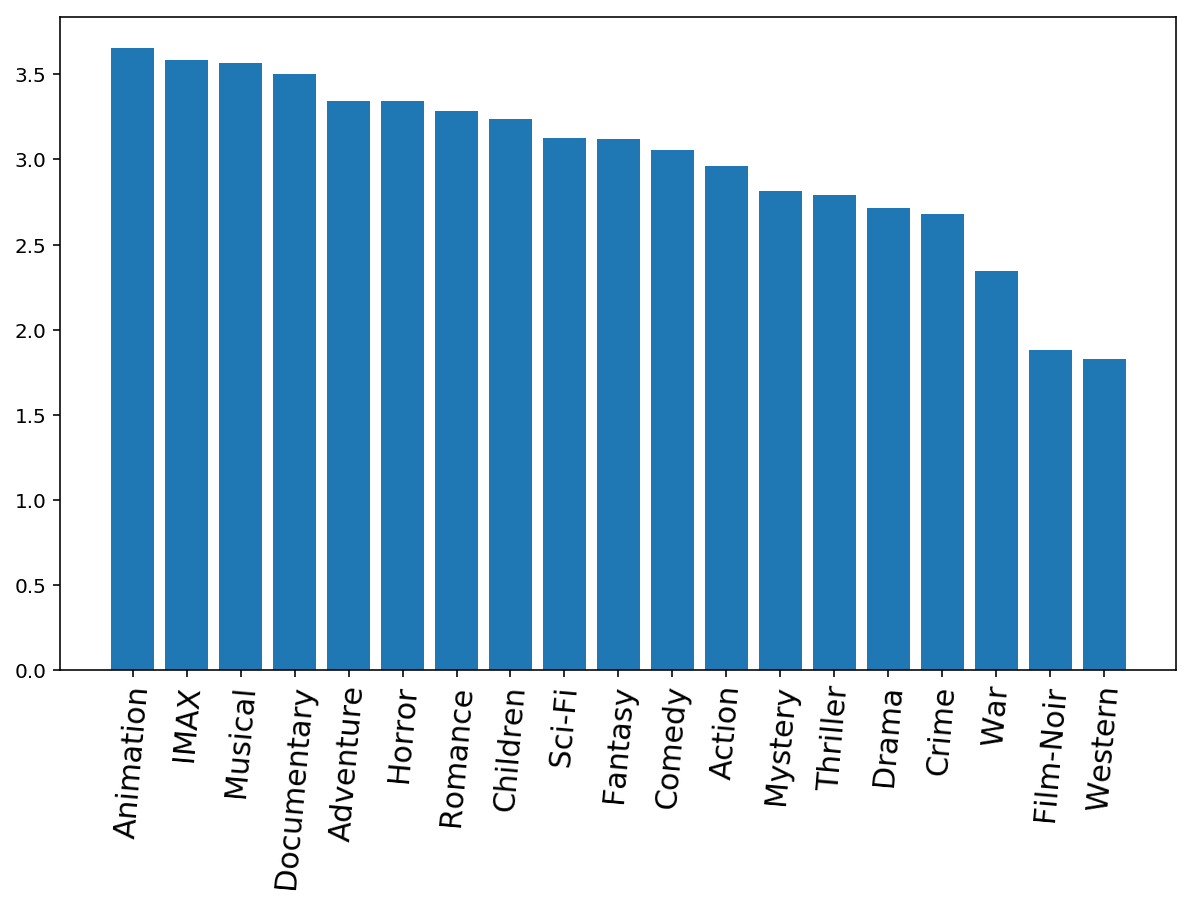

In [38]:
def get_roi(history):
    _, revenues, budgets = zip(*history)
    return sum(revenues) / sum(budgets)

# Some movies store 0 for income or budget. I consider it as garbage and filter it out. 
genre_roi = full_movies_with_money\
    .filter(lambda movie: movie[1] != "(no genres listed)")\
    .flatMap(lambda movie: [(genre, movie[2], movie[3]) for genre in movie[1].split("|")])\
    .filter(lambda movie: movie[1] > 0 and movie[2] > 0)\
    .groupBy(lambda row: row[0])\
    .map(lambda row: (row[0], get_roi(row[1])))\
    .sortBy(lambda row: row[1], ascending=False)

genres, counts = zip(*genre_roi.collect())

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genres, counts)
plt.show()